# 简谐运动

简谐运动（simple harmonic motion, SHM）是微分方程最简单的命题之一。相信很多理工科的朋友对此都不陌生。
如果你手头也有一套《普林斯顿数学指南》，它就在第一卷引论部分的1.5节，作为微分方程的介绍第一个例子；

$$
\begin{equation}
\frac{d^2 x}{dt^2} + k^2 x = 0
\end{equation}
$$

简单的说这个方程表达了质点的受力由其位移和固有频率决定，而后者根据系统的不同，可以是弹性系数与质量，或者摆长和重力加速度等参数的组合。

下面我们尝试将这个方程表达为计算程序的代码。

## 分析

简谐振动方程是个简单的常微分方程，但它是一个二阶微分形式，对于数值计算程序，这是一个小小的难点。

CasADI 支持一阶微分/积分计算，那么我们可以简单的把二阶微分表达为两个一阶微分的联立

$$
\left\{
\begin{align}
&\frac{d x}{dt} = v\\
&\frac{d v}{dt} + k^2x = 0
\end{align}
\right.
$$

## 环境准备

CasADI 是一个综合的符号计算工具，除了数值微分和积分，还提供了最优化算法、求解器等计算工具。

在程序最初，我们先导入 CasADI、numpy 和 matplot 。

In [1]:
from casadi import *
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

## 构造和运行

现在，我们定义：
 - 初始条件
 - 参数假设
 - 时间和步数

真实工程问题中，这些参数的设定是非常困难的。理论上说，我们可以用数学方法计算出这些参数，
CasADi 本身就提供了内置的求解器（也可以选用第三方的求解器）用于计算待定参数，一些最优化方法
对于特定的问题也是非常有效的，MPC（Model Prredicative Control）中一个重要的方向就是用神
经网络拟合这些未知参数的隐函数。但是从我过去一段时间的工作中看，从生产数据中直接训练神经网络
来推导这些参数的效果非常的差，远不如专家们的经验总结。在实际数据和物理学定律之间，仍然存在一
些需要提炼和总结的工程方法。


In [2]:

# 参数设置
k_val = 2.0      # 弹性系数
x0_val = 1.0     # 初始位移
v0_val = 0.0     # 初始速度
T_total = 10.0   # 总仿真时间
N_steps = 200    # 时间步数
dt = T_total / N_steps  # 时间步长


接下来，我们联立速度和加速度的微分方程，实现我们需要的二阶微分。

In [3]:
# 定义符号变量
x = MX.sym('x')  # 位移
v = MX.sym('v')  # 速度
state = vertcat(x, v)
p = MX.sym('k')  # 参数k

# 构建ODE系统: dx/dt = v, dv/dt = -k²x
dxdt = v
dvdt = -p**2 * x
statedot = vertcat(dxdt, dvdt)

CasADi 提供了称为积分器的工具，用于累积微分方程的计算结果，得到其数值解。

In [4]:
# 创建积分器 (CVODES求解器)
# 修正关键点：将时间步长 dt 通过选项字典传递
F = integrator('F', 'cvodes', 
              {'x': state, 'p': p, 'ode': statedot},  # 合并系统方程
              {'tf': dt})  # 积分时间步长通过 'tf' 指定

# 初始化状态
current_state = np.array([x0_val, v0_val])

# 存储结果
times = np.linspace(0, T_total, N_steps + 1)
X = [current_state[0]]
V = [current_state[1]]

# 逐步仿真
for _ in range(N_steps):
    res = F(x0=current_state, p=k_val)
    current_state = res['xf'].full().flatten()
    X.append(current_state[0])
    V.append(current_state[1])


CasADi - 2025-05-11 18:08:36 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:698]


## 计算结果

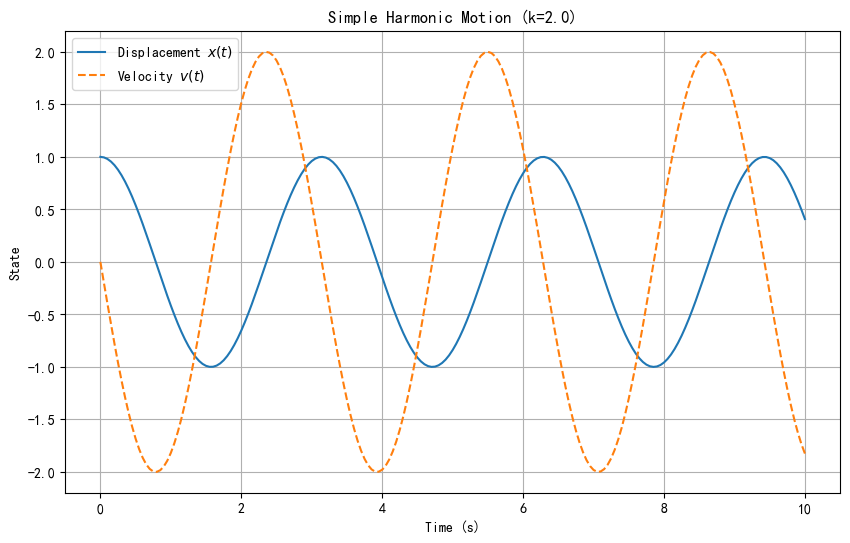

In [5]:

# 转换为numpy数组
X = np.array(X)
V = np.array(V)

# 绘制结果（保持不变）
plt.figure(figsize=(10, 6))
plt.plot(times, X, label='Displacement $x(t)$')
plt.plot(times, V, label='Velocity $v(t)$', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.legend()
plt.title(f'Simple Harmonic Motion (k={k_val})')
plt.grid(True)
plt.show()

简谐运动方程有解析解，我们可以用朴素的python代码计算出

$$
x(t)= A sin(kt) + B cos(kt)
$$

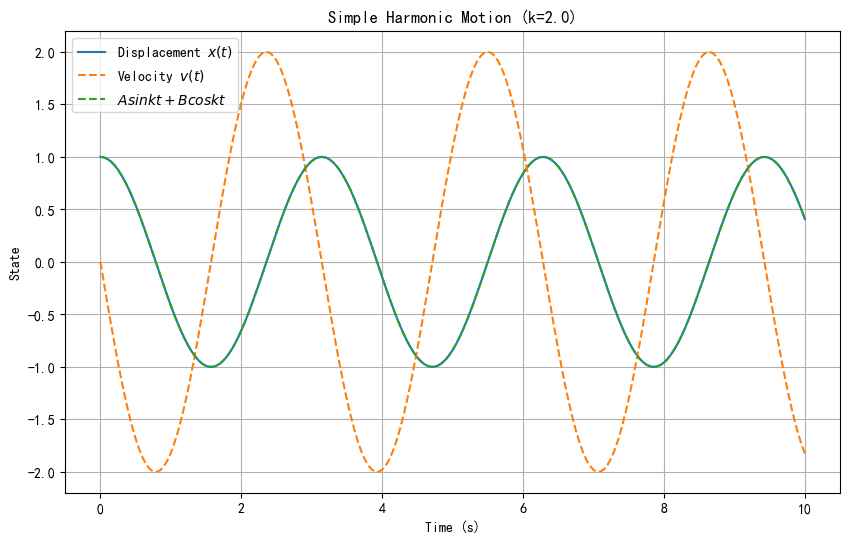

In [6]:
from math import sin, cos
# 转换为numpy数组
X = np.array(X)
V = np.array(V)
A = v0_val/k_val
B = x0_val
ts = [dt*t for t in range(N_steps+1)] # 计算每一步的时间刻度
F = np.array([A * sin(k_val*t) + B * cos(k_val*t) for t in ts])

# 绘制结果（保持不变）
plt.figure(figsize=(10, 6))
plt.plot(times, X, label='Displacement $x(t)$')
plt.plot(times, V, label='Velocity $v(t)$', linestyle='--')
plt.plot(times, F, label='$A sin kt + B cos kt$', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.legend()
plt.title(f'Simple Harmonic Motion (k={k_val})')
plt.grid(True)
plt.show()


这里我们演示了 CasADi 的简单用法，好消息是很多问题，特别是来自课本的问题，就像这个简谐运动方程一样，有非常漂亮的结果。坏
消息是，即使加上新兴的人工智能算法，我们仍没有办法建立一个普遍适用的工程方法论，比之已经解决的问题，未知的那部分是无穷无尽的。

希望在我找到下一份工作之前，可以基于 CasADi 和 Torch ，整理出至少十个微分方程问题的解法，算是对近两个月工作的一个总结，也
是我多年执念的一次和解。
